In [69]:
# Initial imports
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Stats tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Machine Learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

# Explainer
from lime import lime_tabular

# Password for connection string
from config import password

In [70]:
# Load the pga data set dataset from database 
connection_string = f"host=red-team-final.c3yshvuxvm9x.us-east-2.rds.amazonaws.com dbname=red-team port=5432 user=postgres password={password}"
connection = psycopg2.connect(connection_string)

In [71]:
# Establish connection and db
sql = "select * from pga_unsupervised_full"
pga_df = pd.read_sql(sql, connection)
pga_df = pga_df.rename(columns={"money_MONEY":"Winnings"}).drop(columns=["PLAYER NAME", "Year", "SG_tee_green_AVERAGE", "bogey_avoid_% MAKES BOGEY", "btb_ratio_BIRDIE TO BOGEY RATIO", "Class"], axis=1)

In [72]:
# Train, test, split
dtf_train, dtf_test = model_selection.train_test_split(pga_df, test_size=0.4)

dtf_train.drop("Winnings", axis=1)

# Shape info
print(f"X_train shape: {dtf_train.drop('Winnings', axis=1).shape}")
print(f"X_test shape: {dtf_test.drop('Winnings', axis=1).shape}")
print(f"y_train mean: {round(np.mean(dtf_train['Winnings']),2)}")
print(f"y_test mean: {round(np.mean(dtf_test['Winnings']),2)}")

X_train shape: (279, 19)
X_test shape: (186, 19)
y_train mean: 2048992.3
y_test mean: 2041071.67


<AxesSubplot:xlabel='selection', ylabel='features'>

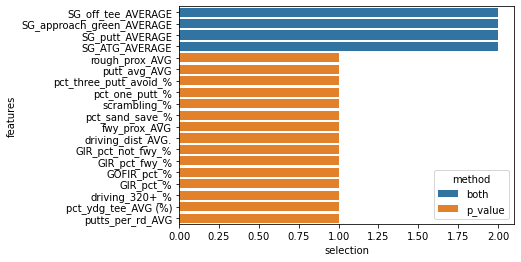

In [73]:
# Selecting features (Code ammended from https://towardsdatascience.com/)
# Define X, y and features

X = dtf_train.drop("Winnings", axis=1).values
y = dtf_train["Winnings"].values
feature_names = dtf_train.drop("Winnings", axis=1).columns

# P-Value
selector = feature_selection.SelectKBest(score_func=feature_selection.f_regression, k=19).fit(X,y)
pvalue_selected_features = feature_names[selector.get_support()]

# Regularization
selector = feature_selection.SelectFromModel(estimator=linear_model.Ridge(alpha=1.0, fit_intercept=True), max_features=19).fit(X,y)
regularization_selected_features = feature_names[selector.get_support()]
 
# Plot
dtf_features = pd.DataFrame({"features":feature_names})
dtf_features["p_value"] = dtf_features["features"].apply(lambda x: "p_value" if x in pvalue_selected_features else "")
dtf_features["num1"] = dtf_features["features"].apply(lambda x: 1 if x in pvalue_selected_features else 0)
dtf_features["regularization"] = dtf_features["features"].apply(lambda x: "regularization" if x in regularization_selected_features else "")
dtf_features["num2"] = dtf_features["features"].apply(lambda x: 1 if x in regularization_selected_features else 0)
dtf_features["method"] = dtf_features[["p_value","regularization"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
dtf_features["selection"] = dtf_features["num1"] + dtf_features["num2"]
dtf_features["method"] = dtf_features["method"].apply(lambda x: "both" if len(x.split()) == 2 else x)
sns.barplot(y="features", x="selection", hue="method", data=dtf_features.sort_values("selection", ascending=False), dodge=False)

In [74]:
# Select features and split for ML model (Code ammended from https://towardsdatascience.com/)
X_names = dtf_train.drop('Winnings', axis=1).columns
X_train = dtf_train[X_names].values
y_train = dtf_train["Winnings"].values
X_test = dtf_test[X_names].values
y_test = dtf_test["Winnings"].values

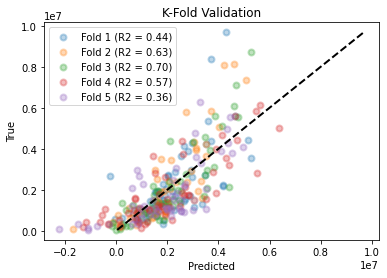

In [75]:
## (Code ammended from https://towardsdatascience.com/)
# Model
model = linear_model.LinearRegression()

# Validation
scores = []
cv = model_selection.KFold(n_splits=5, shuffle=True)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train],
                 y_train[train]).predict(X_train[test])
    true = y_train[test]
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    plt.scatter(prediction, true, lw=2, alpha=0.3, 
                label='Fold %d (R2 = %0.2f)' % (i,score))
    i = i+1
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
         linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation')
plt.legend()
plt.show()

In [76]:
# Train and predict
model.fit(X_train, y_train)
predicted = model.predict(X_test)

In [77]:
## (Code ammended from https://towardsdatascience.com/)
# Results
print("R2 (explained variance):", round(metrics.r2_score(y_test, predicted), 2))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-predicted)/predicted)), 2))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, predicted))))

residuals = y_test - predicted
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = y_test[max_idx], predicted[max_idx]

print("Max Error:", "{:,.0f}".format(max_error))

R2 (explained variance): 0.59
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.56
Mean Absolute Error (Σ|y-pred|/n): 829,442
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 1,082,909
Max Error: 4,623,940


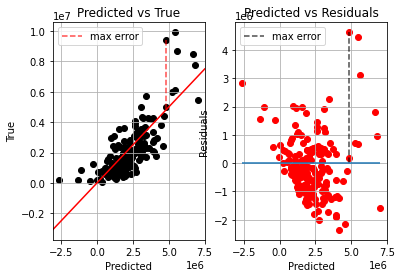

In [78]:
## (Code ammended from https://towardsdatascience.com/)
# Predicted vs True
fig, ax = plt.subplots(nrows=1, ncols=2)
from statsmodels.graphics.api import abline_plot
ax[0].scatter(predicted, y_test, color="black")
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error, color='red', linestyle='--', alpha=0.7, label="max error")
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
# Predicted vs residuals
ax[1].scatter(predicted, residuals, color="red")
ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black', linestyle='--', alpha=0.7, label="max error")
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(predicted), xmax=np.max(predicted))
ax[1].legend()
plt.show()

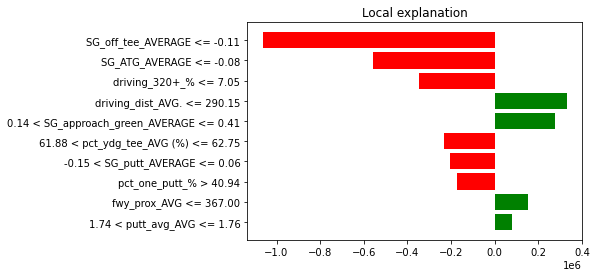

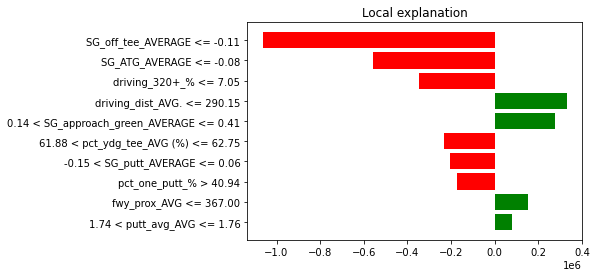

In [79]:
## (Code ammended from https://towardsdatascience.com/)
# Explanation
explainer = lime_tabular.LimeTabularExplainer(training_data=X_train, feature_names=X_names, class_names="Winnings", mode="regression")
explained = explainer.explain_instance(X_test[1], model.predict, num_features=10)
explained.as_pyplot_figure()